# TimeSeries 실습

앞서 살펴본 예제를 바탕으로, 실제로 코드를 작성하는 실습을 진행합니다.

In [ ]:
import csv
import tensorflow as tf
import numpy as np
import urllib

## sunspots 데이터셋 로드

Sunspots 데이터셋을 로드합니다.

다른 데이터셋과는 다르게 csv 데이터를 로드한 다음 필요한 데이터 만을 추출해야합니다.

In [ ]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/Sunspots.csv'
urllib.request.urlretrieve(url, 'sunspots.csv')

## 로드한 데이터 확인

csv 데이터이기에 실제 csv 파일을 열어서 확인해보니 아래 그림과 같은 것을 확인하였습니다.

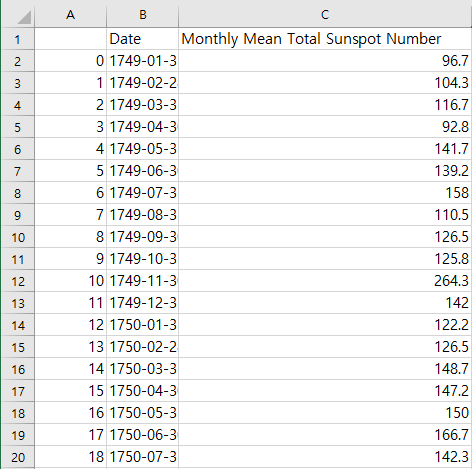

column은 총 3개로 구성되어 있으며, 각각

[index, Date, # of Sunspots] 으로 구성되어 있습니다.

## **MISSION: 데이터 전처리**

##**예시 답안**

sunspots.csv 파일을 보면서 데이터 타입 및 column에 맞게 sunspots과 time_step을 추출하면 됩니다.

series의 경우 밑에 time을 추출한 것과 같이 코드를 구현하면 됩니다.

split의 경우 기준이 되는 3000이 split_time으로 주어지기에 해당 변수를 활용하면 됩니다.


In [ ]:
time_step = []
sunspots = []

with open('sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)

  for row in reader:
    ## sunspots과 time_step 추출
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

## 데이터 추출
series = np.array(sunspots)
min = np.min(series)
max = np.max(series)
series -= min
series /= max

time = np.array(time_step)

split_time = 3000

# 데이터 Train / Validation Split
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

학습 데이터 구성을 위해 Sliding Window 기법을 사용하겠습니다.

window 사이즈를 30, batch 사이즈를 32로 구성하여 학습 데이터를 구성하였습니다.


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)


## **MISSION: 네트워크 정의**

##**예시 답안**

Conv1D 레이어를 추가하여 Input shape를 지정해줍니다.

이후 LSTM 레이어를 추가합니다.

여러개의 LSTM 레이어를 쌓기 위해서는 reutrn_sequences=True 옵션을 추가합니다.

LSTM 레이어와 Output 레이어 사이에 적당한 크기의 Dense 레이어를 추가합니다.

예시와는 다르게 LSTM 레이어와 Dense 레이어만을 활용하여 구현해도 성능만 나온다면 문제 없습니다.

In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=60, kernel_size=10,
                             strides=1, padding="causal",
                             activation="relu", input_shape=[None, 1]),
        tf.keras.layers.LSTM(60, return_sequences=True),
        tf.keras.layers.LSTM(60, return_sequences=True),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(1)
    ])

## **MISSION: 네트워크 학습**

##**예시 답안**

Loss는 Huber, Optimizer는 SGD, Metrics은 mae를 사용하여 compile하였습니다.

Loss는 mae, mse를 사용하여도 되며, Optimizer도 adam 등을 사용해도 됩니다.

<br>

학습은 적당히 50 Epoch을 실시하였고, 더 줄이거나 늘려도 문제 없습니다.

In [ ]:
# Compile and Training

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9), metrics=['mae'])
model.fit(train_set, epochs=50)

## Validation 평가

아까 데이터 구성에서 빼둔 236건의 Validation 데이터가 있습니다.

이 데이터를 활용하여 학습 된 모델의 성능을 평가합니다.

<br>

해당 MAE가 0.12 이하로 떨어진다면 모델 설계 및 학습을 잘 실시한 것 입니다.


In [ ]:
import math

def model_forecast(model, series, window_size):
   ds = tf.data.Dataset.from_tensor_slices(series)
   ds = ds.window(window_size, shift=1, drop_remainder=True)
   ds = ds.flat_map(lambda w: w.batch(window_size))
   ds = ds.batch(32).prefetch(1)
   forecast = model.predict(ds)
   return forecast


window_size = 30
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

result = tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

print(result)
